In [103]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import pandas as pd
import time
from os.path import join
import json 
import numpy as np 
from tqdm import tqdm
import seaborn as sns
from os import listdir, path
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno


from matplotlib.colors import ListedColormap
import plotly.graph_objs as go



In [105]:
from ploting_functions import plot_histogram_boxplot, make_bar_plot,make_bar_plot_cat, plot_histogram_boxplot_cat


In [106]:
%autoreload 2


In [107]:

def map_failure(x):
    if pd.isna(x):
        return 0
    else:
        x  = int(x.replace('comp',''))
    return x

def map_error(x):
    if pd.isna(x):
        return 0
    else:
        x  = int(x.replace('error',''))
    return x


In [139]:
data_dir = '/workspaces/predictive_maintenance/data/raw'
training_data_dir = '/workspaces/predictive_maintenance/data/preprocessed_data/training_data'


listdir(data_dir)

# keep only the files that end with .parquet
files = [join(data_dir,f)  for f in listdir(data_dir) if f.endswith('.parquet')]


# creat a dict key is the file name and value is the path 
files_dict = {f.split('/')[-1].split('.')[0]:f for f in files}
files_dict

{'PdM_failures': '/workspaces/predictive_maintenance/data/raw/PdM_failures.parquet',
 'PdM_machines': '/workspaces/predictive_maintenance/data/raw/PdM_machines.parquet',
 'PdM_telemetry2': '/workspaces/predictive_maintenance/data/raw/PdM_telemetry2.parquet',
 'PdM_errors': '/workspaces/predictive_maintenance/data/raw/PdM_errors.parquet',
 'PdM_maint': '/workspaces/predictive_maintenance/data/raw/PdM_maint.parquet',
 'PdM_telemetry': '/workspaces/predictive_maintenance/data/raw/PdM_telemetry.parquet'}

In [140]:
# read all the files into dataframes, the name of the dataframe is df_ + the name of the file


df_PdM_errors = pd.read_parquet(files_dict['PdM_errors'])
df_PdM_maint = pd.read_parquet(files_dict['PdM_maint'])
df_PdM_telemetry = pd.read_parquet(files_dict['PdM_telemetry'])
df_PdM_failures = pd.read_parquet(files_dict['PdM_failures'])
df_PdM_machines = pd.read_parquet(files_dict['PdM_machines'])
    

In [141]:
# convert the date columns to datetime
df_PdM_errors['datetime'] = pd.to_datetime(df_PdM_errors['datetime'])
df_PdM_maint['datetime'] = pd.to_datetime(df_PdM_maint['datetime'])
df_PdM_telemetry['datetime'] = pd.to_datetime(df_PdM_telemetry['datetime'])
df_PdM_failures['datetime'] = pd.to_datetime(df_PdM_failures['datetime'])



## leave last 3 months for testing


In [142]:
train_end_date = '2015-10-01'
df_PdM_telemetry = df_PdM_telemetry[df_PdM_telemetry['datetime'] < train_end_date]
df_PdM_errors = df_PdM_errors[df_PdM_errors['datetime'] < train_end_date]
df_PdM_maint = df_PdM_maint[df_PdM_maint['datetime'] < train_end_date]
df_PdM_failures = df_PdM_failures[df_PdM_failures['datetime'] < train_end_date]

# save df_PdM_telemetry df_PdM_errors df_PdM_maint df_PdM_failures to /workspaces/predictive_maintenance/data/preprocessed_data/training_data
df_PdM_telemetry.to_parquet(join(training_data_dir,'df_PdM_telemetry.parquet'))
df_PdM_errors.to_parquet(join(training_data_dir,'df_PdM_errors.parquet'))
df_PdM_maint.to_parquet(join(training_data_dir,'df_PdM_maint.parquet'))
df_PdM_failures.to_parquet(join(training_data_dir,'df_PdM_failures.parquet'))


In [143]:
# Funciones reutilizables
def apply_failure_mapping(df, map_func):
    df['failure'] = df.failure.apply(map_func)
    df['failure_binary'] = df.failure.apply(lambda x: 1 if x > 0 else 0)
    return df



# Merges
df_failures_machines = df_PdM_failures.merge(df_PdM_machines, on='machineID', how='left')
df_failures_telemetry = df_PdM_telemetry.merge(df_PdM_failures, on=['datetime', 'machineID'], how='left')
df_failures_errors = df_PdM_errors.merge(df_PdM_failures, on=['datetime', 'machineID'], how='outer')
df_PdM_telemetry_machines = df_PdM_telemetry.merge(df_PdM_machines, on='machineID', how='left')
df_PdM_failures_machines = df_PdM_failures.merge(df_PdM_machines, on='machineID', how='left')

# Aplicar funciones
df_failures_machines = apply_failure_mapping(df_failures_machines, map_failure)
df_failures_telemetry = apply_failure_mapping(df_failures_telemetry, map_failure)
df_failures_errors = apply_failure_mapping(df_failures_errors, map_failure)
df_failures_errors.errorID = df_failures_errors.errorID.apply(map_error)
df_failures_machines['model'] = df_failures_machines['model'].apply(lambda x: x.replace('model','')).astype(int)



In [144]:

# save df_failures_telemetry df_failures_machines df_failures_errors to training_data_dir 
df_failures_telemetry.to_parquet(join(training_data_dir,'df_failures_telemetry.parquet'))
df_failures_machines.to_parquet(join(training_data_dir,'df_failures_machines.parquet'))
df_failures_errors.to_parquet(join(training_data_dir,'df_failures_errors.parquet'))
df_PdM_telemetry_machines.to_parquet(join(training_data_dir,'df_PdM_telemetry_machines.parquet'))
df_PdM_failures_machines.to_parquet(join(training_data_dir,'df_PdM_failures_machines.parquet'))


# load df_failures_telemetry df_failures_machines df_failures_errors from training_data_dir
df_failures_telemetry = pd.read_parquet(join(training_data_dir,'df_failures_telemetry.parquet'))
df_failures_machines = pd.read_parquet(join(training_data_dir,'df_failures_machines.parquet'))
df_failures_errors = pd.read_parquet(join(training_data_dir,'df_failures_errors.parquet'))
df_PdM_telemetry_machines = pd.read_parquet(join(training_data_dir,'df_PdM_telemetry_machines.parquet'))
df_PdM_failures_machines = pd.read_parquet(join(training_data_dir,'df_PdM_failures_machines.parquet'))


In [145]:
vars_telemetry = ['volt', 'rotate', 'pressure', 'vibration']

In [146]:
base_color = '#3B3B3B'


# Analisis Univariado

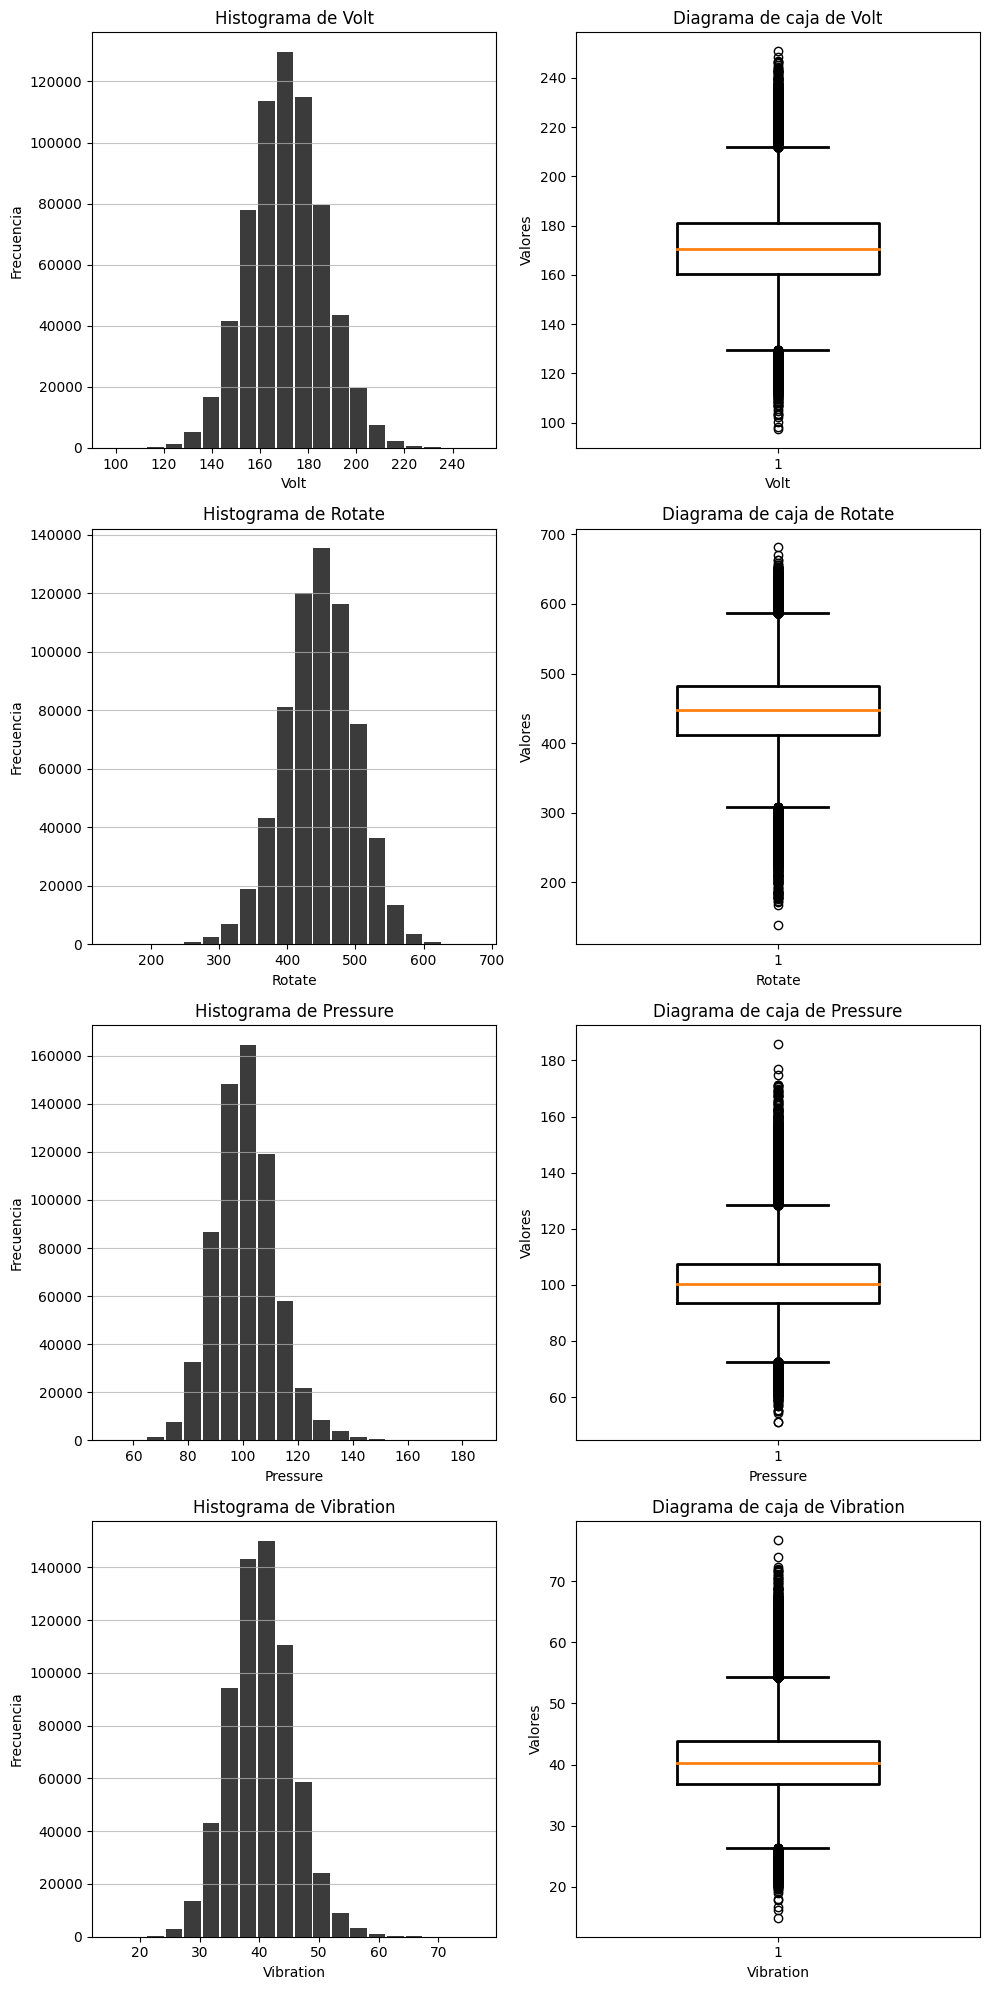

In [147]:
plot_histogram_boxplot(df_PdM_telemetry, vars_telemetry,color=base_color)

In [148]:

df_PdM_machines.head(   )

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


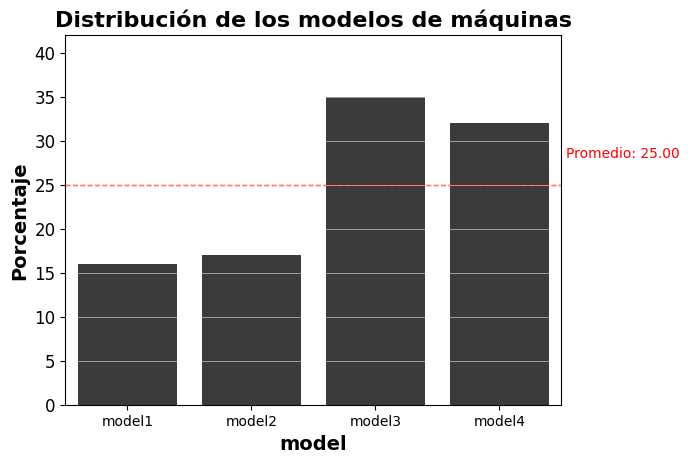

In [149]:

title  = 'Distribución de los modelos de máquinas'
target = 'model'
make_bar_plot(df_PdM_machines, target, title, key_map={},color='#3B3B3B')

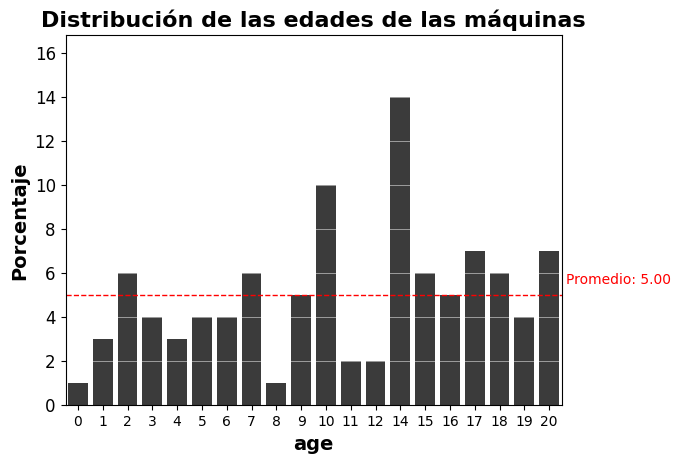

In [150]:
title = 'Distribución de las edades de las máquinas'
target = 'age'
make_bar_plot(df_PdM_machines, target, title, key_map={},color='#3B3B3B')

In [151]:
df_PdM_failures.head(   )

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


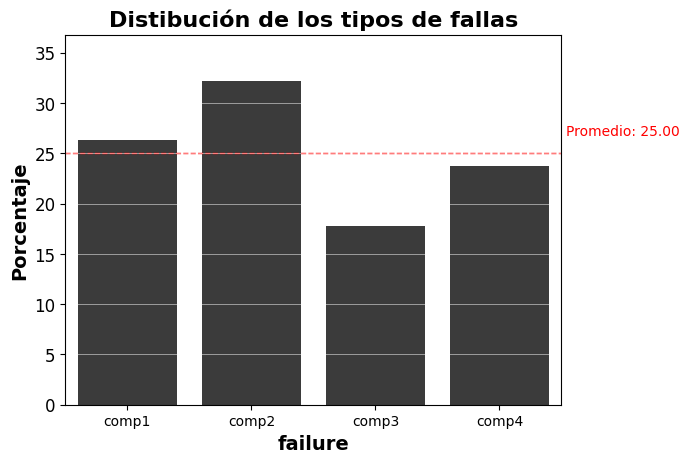

In [152]:
title = 'Distibución de los tipos de fallas'
target = 'failure'
make_bar_plot(df_PdM_failures, target, title, key_map={},color='#3B3B3B')

In [153]:
df_PdM_errors.head( )

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


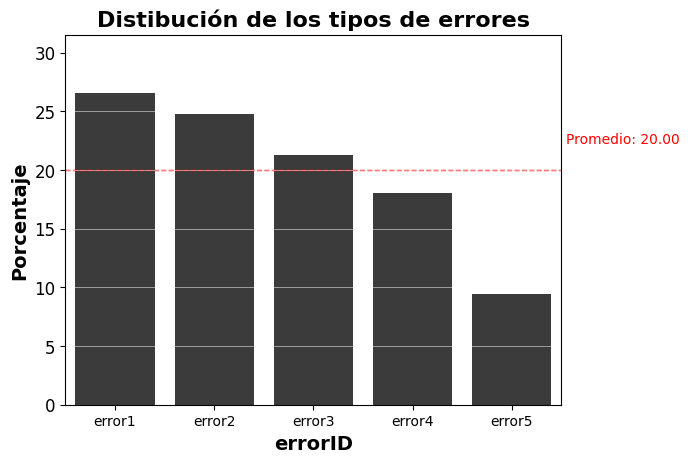

In [154]:
title = 'Distibución de los tipos de errores'
target = 'errorID'
make_bar_plot(df_PdM_errors, target, title, key_map={},color='#3B3B3B')

In [155]:
df_PdM_maint.head( )

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


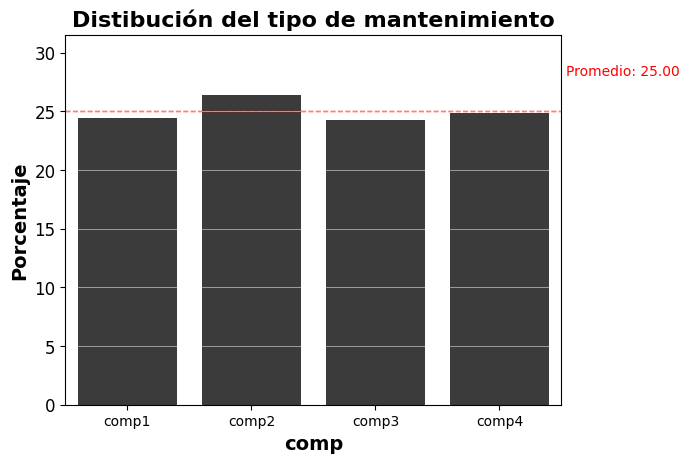

In [156]:
title = 'Distibución del tipo de mantenimiento'
target = 'comp'
make_bar_plot(df_PdM_maint, target, title, key_map={},color='#3B3B3B')

# Analisis Bivariado

In [157]:

color_palette = ListedColormap([
    '#1F3A70',  # Azul oscuro
    '#4A90E2',  # Azul claro
    '#D0D0D0',  # Gris
    '#8F0E26',  # Rojo
    '#0E8F0F',  # Verde
])

In [158]:
df_PdM_telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [159]:
machine_models = sorted(df_PdM_telemetry_machines['model'].unique())

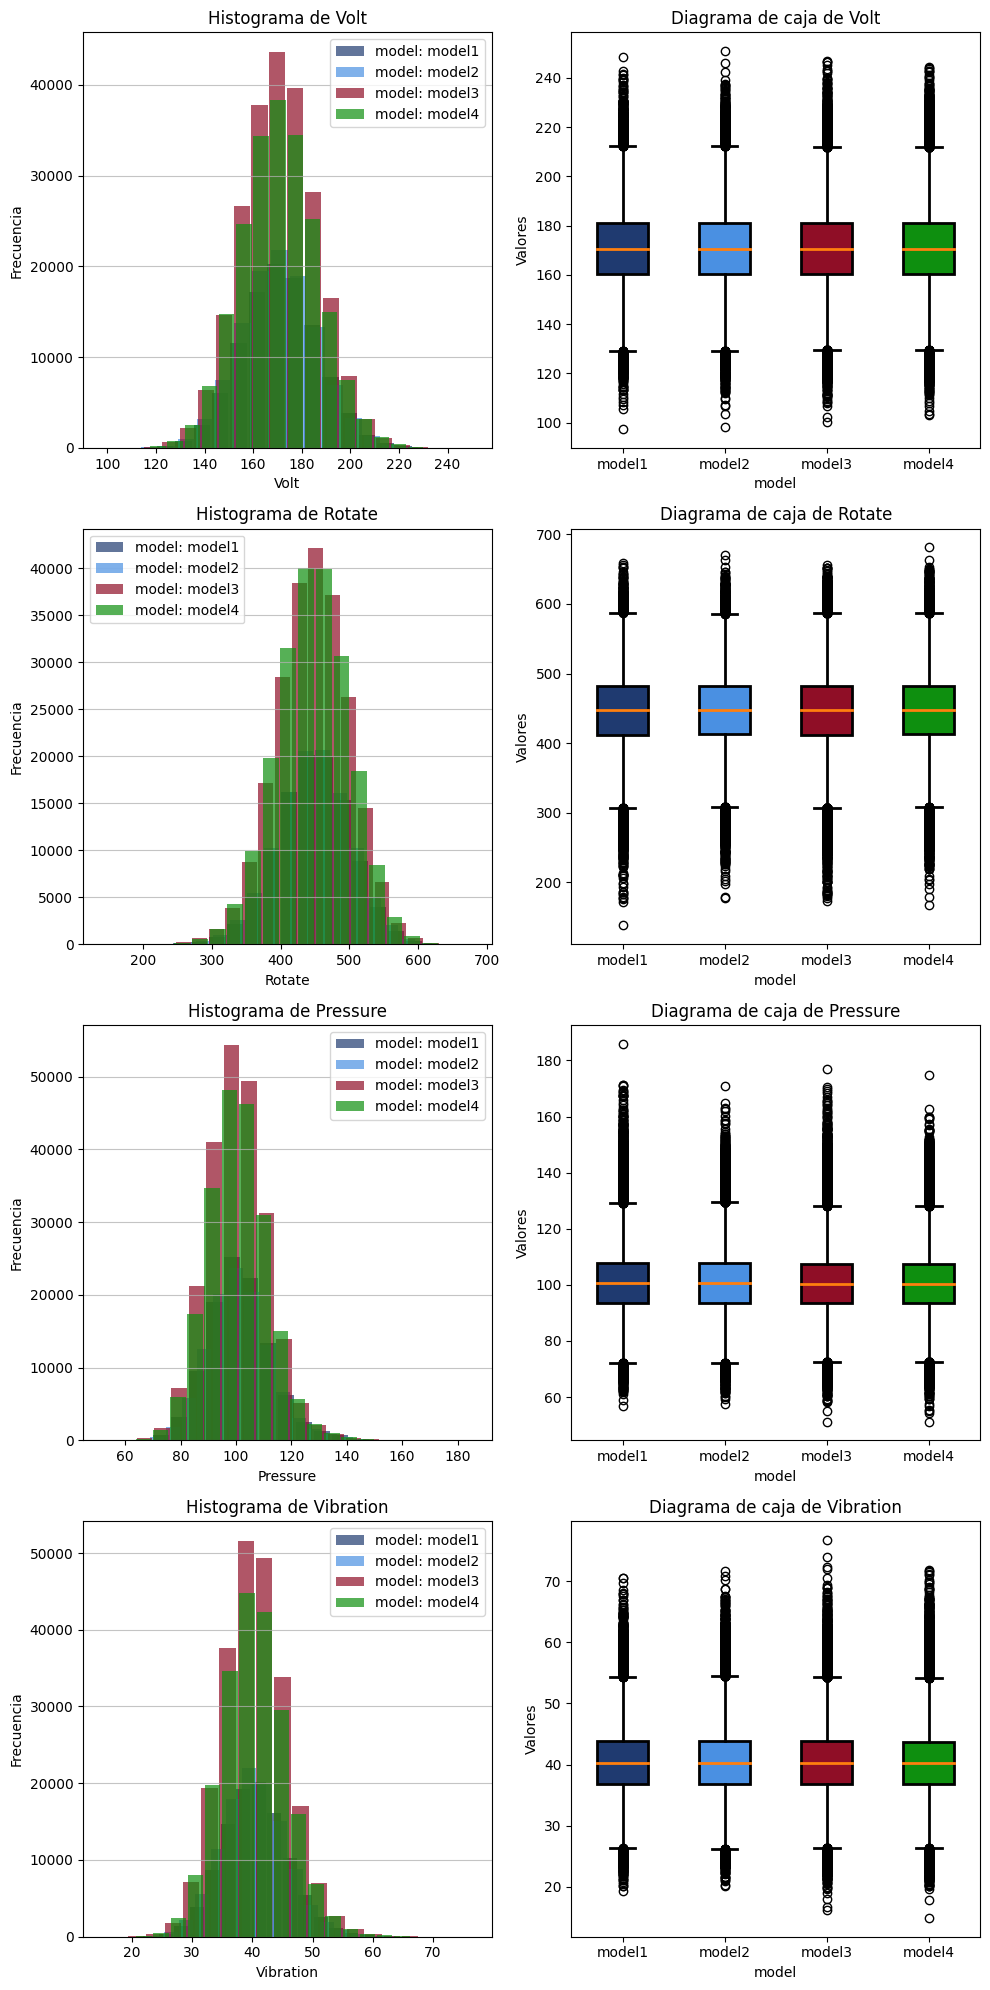

In [160]:
category = 'model'
plot_histogram_boxplot_cat(df_PdM_telemetry_machines, vars_telemetry, category,machine_models,color_palette=color_palette)

In [161]:
target_list = df_PdM_failures['failure'].sort_values().unique()

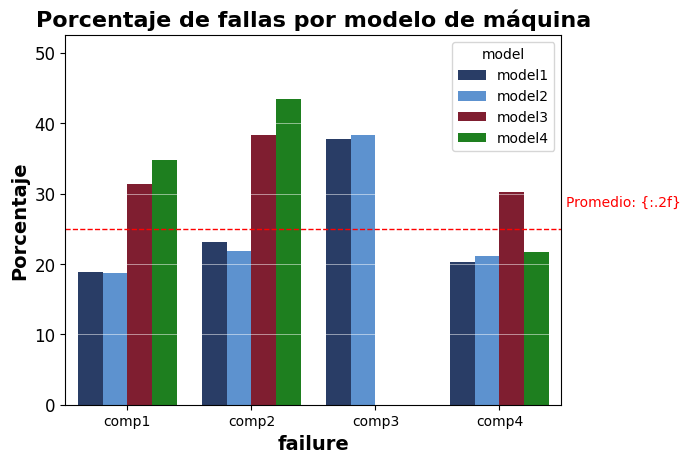

In [162]:
titulo = 'Porcentaje de fallas por modelo de máquina'

make_bar_plot_cat(df_PdM_failures_machines, 'failure', 'model',machine_models, titulo,color_palette=color_palette,target_list=target_list)

In [163]:
df_failures_machines

,datetime,machineID,failure,model,age,failure_binary
0,2015-01-05 06:00:00,1,4,3,18,1
1,2015-03-06 06:00:00,1,1,3,18,1
2,2015-04-20 06:00:00,1,2,3,18,1
3,2015-06-19 06:00:00,1,4,3,18,1
4,2015-09-02 06:00:00,1,4,3,18,1
...,...,...,...,...,...,...
576,2015-07-17 06:00:00,99,3,1,14,1
577,2015-08-01 06:00:00,99,2,1,14,1
578,2015-08-31 06:00:00,99,3,1,14,1
579,2015-02-12 06:00:00,100,1,4,5,1


In [170]:
telemetria_fallas_30_antes = pd.DataFrame()
telemetria_sin_fallas_30 = pd.DataFrame()
tamano_ventana = 25



for i,ix in enumerate(df_failures_telemetry.query('failure_binary == 1').index):

    #df_failures_telemetry['FallaId'] = i
    df_segmento = df_failures_telemetry.iloc[ix-tamano_ventana:ix+1]  
    df_segmento['Id'] = i
    df_segmento['Falla'] = True
    df_segmento['index'] = np.arange(0,tamano_ventana+1)
    telemetria_fallas_30_antes = pd.concat([telemetria_fallas_30_antes,df_segmento ])


    df_segmento = df_failures_telemetry.iloc[ix+1:ix+tamano_ventana+2]
    df_segmento['Id'] =  i
    df_segmento['Falla'] = False
    df_segmento['index'] = np.arange(0,tamano_ventana+1)
    telemetria_sin_fallas_30 = pd.concat([telemetria_sin_fallas_30,df_segmento ])  

telemetria_sin_fallas_30 = telemetria_sin_fallas_30.query('failure_binary != 1')




/tmp/ipykernel_1476/2749511208.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1476/2749511208.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1476/2749511208.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1

In [169]:
telemetria_sin_fallas_30

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary,FallaId,index
97,2015-01-05 07:00:00,1,155.511452,498.398435,103.068134,33.270415,0,0,10000,0
98,2015-01-05 08:00:00,1,172.439821,392.124959,108.135159,39.477497,0,0,10000,1
99,2015-01-05 09:00:00,1,138.826437,451.348967,126.464580,38.257462,0,0,10000,2
100,2015-01-05 10:00:00,1,177.278402,403.199389,100.858613,38.776021,0,0,10000,3
101,2015-01-05 11:00:00,1,180.451532,494.681408,103.810360,39.822763,0,0,10000,4
...,...,...,...,...,...,...,...,...,...,...
654157,2015-09-11 04:00:00,100,164.847751,449.620728,100.747743,36.387982,0,0,10580,21
654158,2015-09-11 05:00:00,100,186.137093,502.231922,110.694809,40.827464,0,0,10580,22
654159,2015-09-11 06:00:00,100,164.551845,532.907758,91.463175,35.459129,0,0,10580,23
654160,2015-09-11 07:00:00,100,172.254393,517.909384,105.882832,40.548881,0,0,10580,24


In [180]:


def graficar_telemetria_fallas(telemetria_fallas, nrows, titulo, variable_y):
    telemetria_fallas_filtrado = telemetria_fallas.query('Id <= @nrows')
    fig = go.Figure()
    for falla_id, datos in telemetria_fallas_filtrado.groupby('Id'):
        fig.add_trace(go.Scatter(x=datos['index'], y=datos[variable_y], mode='lines', line=dict(color='gray'), name=f'Falla {falla_id}'))
    promedio = telemetria_fallas_filtrado.groupby('index').mean()[variable_y]
    fig.add_trace(go.Scatter(x=promedio.index, y=promedio.values, mode='lines', line=dict(color='red'), name='Promedio'))
    fig.update_xaxes(title_text='index')
    fig.update_yaxes(title_text=variable_y)
    fig.update_layout(title=titulo)
    fig.show()

In [181]:
def generate_failure_segments(df, window_size):
    def extract_segments(df, index, window_size):
        before_failure = df.iloc[index - window_size:index + 1].copy()
        after_failure = df.iloc[index + 1:index + window_size + 2].copy()
        return before_failure, after_failure

    def process_segments(df, failure_id, window_size, is_failure):
        df = df.assign(Id=failure_id, Falla=is_failure, index=np.arange(0, window_size + 1))
        return df

    telemetria_fallas_antes = pd.DataFrame()
    telemetria_sin_fallas = pd.DataFrame()

    failure_indices = df.query('failure_binary == 1').index

    for i, ix in enumerate(failure_indices):
        segment_before, segment_after = extract_segments(df, ix, window_size)

        segment_before = process_segments(segment_before, i, window_size, True)
        telemetria_fallas_antes = pd.concat([telemetria_fallas_antes, segment_before])

        segment_after = process_segments(segment_after, i, window_size, False)
        telemetria_sin_fallas = pd.concat([telemetria_sin_fallas, segment_after])

    return telemetria_fallas_antes, telemetria_sin_fallas


In [182]:
tamano_ventana = 25
telemetria_fallas_25_antes, telemetria_sin_fallas_25 = generate_failure_segments(df_failures_telemetry, tamano_ventana)


In [191]:
df_failures_telemetry['failure'].unique()

array([0, 4, 1, 2, 3])

In [183]:
telemetria_fallas_25_antes

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary,Id,Falla,index
71,2015-01-04 05:00:00,1,170.648661,464.189726,103.742947,58.457667,0,0,0,True,0
72,2015-01-04 06:00:00,1,165.010140,448.468838,97.709630,48.238941,0,0,0,True,1
73,2015-01-04 07:00:00,1,142.666469,433.279499,118.853452,54.848731,0,0,0,True,2
74,2015-01-04 08:00:00,1,191.168936,479.615136,101.999663,52.882567,0,0,0,True,3
75,2015-01-04 09:00:00,1,157.436263,438.091311,113.100915,53.695544,0,0,0,True,4
...,...,...,...,...,...,...,...,...,...,...,...
654131,2015-09-10 02:00:00,100,197.067317,513.200942,95.422995,40.437980,0,0,580,True,21
654132,2015-09-10 03:00:00,100,185.310093,462.133184,105.136787,35.817124,0,0,580,True,22
654133,2015-09-10 04:00:00,100,186.687188,443.453437,92.263949,45.004588,0,0,580,True,23
654134,2015-09-10 05:00:00,100,176.914053,398.675581,100.978336,42.792983,0,0,580,True,24


In [184]:
titulo = 'Voltaje  fallas'
graficar_telemetria_fallas(telemetria_fallas_30_antes, 5,titulo, 'volt')

/tmp/ipykernel_1476/3710021707.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [186]:
titulo = 'Voltaje sin fallas'
target = 'volt'
graficar_telemetria_fallas(telemetria_sin_fallas_30, 5,titulo,target)

/tmp/ipykernel_1476/3710021707.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [192]:
def generate_failure_segments(df, window_size):
    def extract_segments(df, index, window_size):
        before_failure = df.iloc[index - window_size:index + 1].copy()
        after_failure = df.iloc[index + 1:index + window_size + 2].copy()
        return before_failure, after_failure

    def process_segments(df, failure_id, window_size, failure_type):
        df = df.assign(Id=failure_id, FailureType=failure_type, index=np.arange(0, window_size + 1))
        return df

    failure_types = df['failure'].unique()
    segments_by_failure = {}

    for failure_type in failure_types:
        segments_before_failure = pd.DataFrame()
        segments_after_failure = pd.DataFrame()
        
        failure_indices = df.query(f'failure == {failure_type}').index

        for i, ix in enumerate(failure_indices):
            segment_before, segment_after = extract_segments(df, ix, window_size)

            segment_before = process_segments(segment_before, i, window_size, failure_type)
            segments_before_failure = pd.concat([segments_before_failure, segment_before])

            segment_after = process_segments(segment_after, i, window_size, failure_type)
            segments_after_failure = pd.concat([segments_after_failure, segment_after])

        segments_by_failure[failure_type] = {
            'before_failure': segments_before_failure,
            'after_failure': segments_after_failure,
        }

    return segments_by_failure


In [195]:
tamano_ventana = 25
segments_by_failure = generate_failure_segments(df_failures_telemetry, tamano_ventana)


KeyboardInterrupt: 

In [ ]:
segments_by_failure

In [65]:
df_dataset_telemetria = pd.concat([telemetria_fallas_30_antes,telemetria_sin_fallas_30])

In [66]:
datos_telemetria_agg = df_dataset_telemetria.groupby('FallaId').agg(mean_volt = ('volt', 'mean'),
                                                mean_rot = ('rotate', 'mean'),
                                                mean_press = ('pressure', 'mean'),
                                                mean_vib = ('vibration', 'mean'),
                                                max_volt = ('volt', 'max'),
                                                max_rot = ('rotate', 'max'),
                                                max_press = ('pressure', 'max'),
                                                max_vib = ('vibration', 'max'),
                                                min_volt = ('volt', 'min'),
                                                min_rot = ('rotate', 'min'),
                                                min_press = ('pressure', 'min'),
                                                min_vib = ('vibration', 'min'),
                                                std_volt = ('volt', 'std'),
                                                std_rot = ('rotate', 'std'),
                                                std_press = ('pressure', 'std'),
                                                std_vib = ('vibration', 'std'),
                                                failure_binary = ('failure_binary', 'max'),
                                                failure = ('failure', 'max')
                                                
)


In [67]:
df_dataset_telemetria = pd.read_parquet('../data/interim/dataset_telemetria_ts.parquet')
datos_telemetria_agg = pd.read_parquet('../data/interim/dataset_telemetria_ts_agg.parquet')


<AxesSubplot: xlabel='mean_vib', ylabel='mean_volt'>

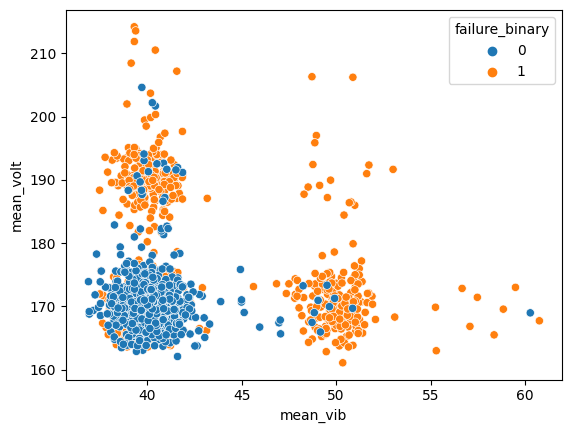

In [71]:
sns.scatterplot(data=datos_telemetria_agg, x="mean_vib", y="mean_volt", hue="failure_binary")


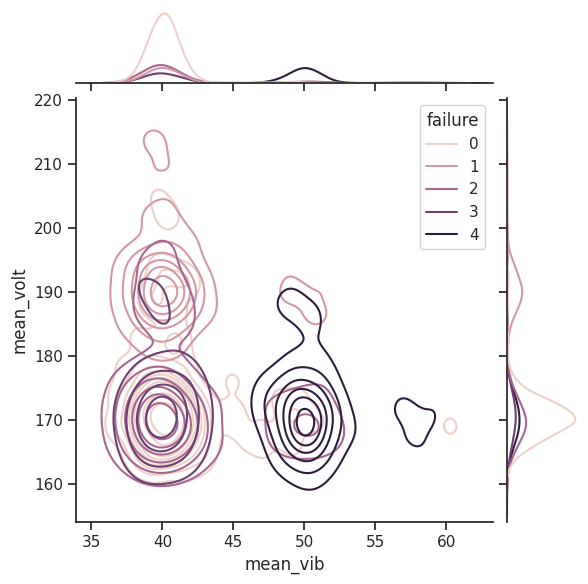

In [72]:
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=datos_telemetria_agg,
    x="mean_vib", y="mean_volt", hue="failure",
    kind="kde",
)

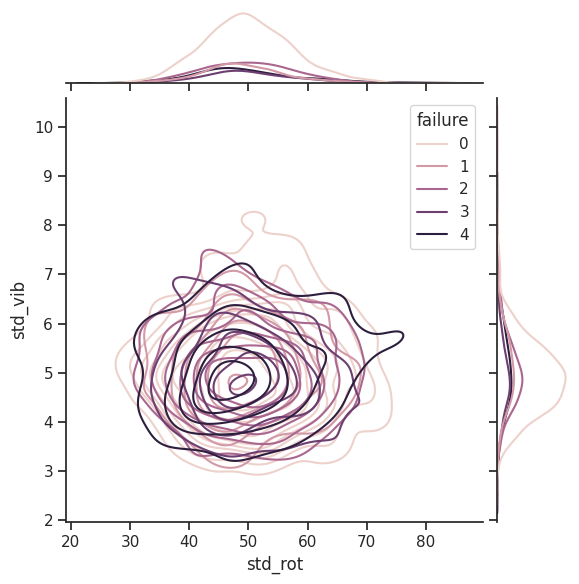

In [73]:
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=datos_telemetria_agg,
    x="std_rot", y="std_vib", hue="failure",
    kind="kde",
)

In [75]:
# PCA

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px



features_agg = ['mean_volt', 'mean_rot', 'mean_press', 'mean_vib', 'max_volt',
       'max_rot', 'max_press', 'max_vib', 'min_volt', 'min_rot', 'min_press',
       'min_vib', 'std_volt', 'std_rot', 'std_press', 'std_vib']

In [83]:
# calcular PCA para datos_telemetria_agg
# normalizar los datos
scaler = StandardScaler() 
scaler.fit(datos_telemetria_agg[features_agg])
# calcular PCA
pca = PCA(n_components=2)
pca.fit(datos_telemetria_agg[features_agg])
# transformar los datos
datos_telemetria_agg_pca = pca.transform(datos_telemetria_agg[features_agg])
# crear un dataframe con los datos transformados
datos_telemetria_agg_pca = pd.DataFrame(datos_telemetria_agg_pca, columns=['PC1', 'PC2'])
# agregar la variable target
datos_telemetria_agg_pca['failure_binary'] = datos_telemetria_agg['failure_binary'].values
datos_telemetria_agg_pca['failure'] = datos_telemetria_agg['failure'].values


In [84]:
# graficar 
fig = px.scatter(datos_telemetria_agg_pca, x='PC1', y='PC2',color='failure_binary', title='PCA')
fig.show()


In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def calcular_pca(datos, features, num_componentes):
    # normalizar los datos
    scaler = StandardScaler() 
    scaler.fit(datos[features])
    # calcular PCA
    pca = PCA(n_components=num_componentes)
    pca.fit(datos[features])
    # transformar los datos
    datos_pca = pca.transform(datos[features])
    # crear un dataframe con los datos transformados
    columnas_pca = [f'PC{i+1}' for i in range(num_componentes)]
    datos_pca_df = pd.DataFrame(datos_pca, columns=columnas_pca)
    # agregar las variables de destino
    datos_pca_df['failure_binary'] = datos['failure_binary'].values
    datos_pca_df['failure'] = datos['failure'].values
    
    return datos_pca_df


In [87]:
import plotly.express as px
datos_telemetria_agg_pca = calcular_pca(datos_telemetria_agg, features_agg, 3)
# Convertir la variable failure a un tipo de datos categórico
datos_telemetria_agg_pca['failure'] = datos_telemetria_agg_pca['failure'].astype('category')

# Crear un diccionario de colores independientes para cada categoría de la variable failure
color_map = {'none': 'blue', 'comp1': 'red', 'comp2': 'green'}

fig = px.scatter_3d(datos_telemetria_agg_pca, x='PC1', y='PC2', z='PC3', color='failure', color_discrete_map=color_map, title='PCA')
fig.show()
